In [9]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.transform import probabilistic_hough_line
from mpl_toolkits.mplot3d import Axes3D
import math
import cv2

In [10]:
neurons = 100
x, y = np.linspace(0,neurons,neurons), np.linspace(0,neurons,neurons)
X, Y = np.meshgrid(x,y)

xo, yo = neurons/2, neurons/2
theta = 0.5 * np.arctan2(Y-yo, X-xo)

Z = np.exp(1j * 2 *theta)
noise_std = np.radians(5)
Z *= np.exp(1j * 2 *np.random.normal(0, noise_std, Z.shape))

Z_real = gaussian_filter(Z.real, sigma = 1)
Z_imag = gaussian_filter(Z.imag, sigma = 1)
Z_field = Z_real + 1j * Z_imag



In [11]:

preferred_orientations = np.angle(Z_field) / 2
kappa = 3
R0 = 0


In [12]:
def FI_map(stimulus_orientations, preferred_orientations = preferred_orientations, xo=xo, yo=yo, R0= 0, kappa = 3):

  FI_total = np.zeros_like(preferred_orientations)

  for theta_stim in stimulus_orientations:
    R = R0 + np.exp(kappa * (np.cos(2*(preferred_orientations - theta_stim)) - 1))
    dr_dtheta = -2 * kappa * np.sin(2*(preferred_orientations - theta_stim)) * R
    FI = (dr_dtheta**2) / (R + 1e-12)
    FI_total += FI

  FI_avg = FI_total / N

  return FI_avg[int(xo),int(yo)]

N_values = np.unique(np.logspace(0, 2.5, 15).astype(int))
num_trials = 30
FI_center_mean = []
FI_center_var = []


for N in N_values:
    FI_samples = []

    theta_grid = np.linspace(0, np.pi , N, endpoint = False)
    preferred_theta = np.pi/4
    prior = np.exp(kappa * np.cos(2 * (theta_grid - preferred_theta)))
    prior /= prior.sum()

    for trial in range(num_trials):

        stimulus_orientations = np.random.choice(
            theta_grid,
            size=N,
            replace=True
        )


        FI0 = FI_map(
            stimulus_orientations,
            preferred_orientations,
            xo, yo,
            R0, kappa
        )

        FI_samples.append(FI0)

    FI_samples = np.array(FI_samples)

    FI_center_mean.append(FI_samples.mean())
    FI_center_var.append(FI_samples.var())

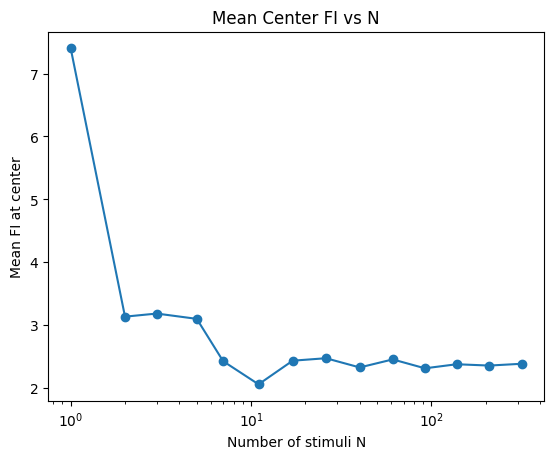

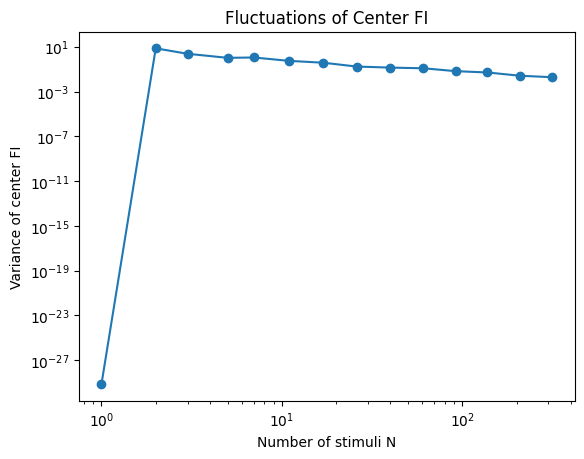

In [13]:
plt.figure()
plt.plot(N_values, FI_center_mean, 'o-')
plt.xscale('log')
plt.xlabel('Number of stimuli N')
plt.ylabel('Mean FI at center')
plt.title('Mean Center FI vs N')
plt.show()

plt.figure()
plt.plot(N_values, FI_center_var, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of stimuli N')
plt.ylabel('Variance of center FI')
plt.title('Fluctuations of Center FI')
plt.show()
